In [ ]:
from random import seed
from random import randrange
from math import sqrt
from sklearn.datasets import load_breast_cancer

# Cargar breast cancer dataset de scikit-learn
data = load_breast_cancer()
X, y = data.data, data.target

# Combine características y etiquetas en un conjunto de datos
dataset = [list(X[i]) + [y[i]] for i in range(len(X))]

# Dividir un conjunto de datos en k pliegues
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calcular el porcentaje de precisión
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluar un algoritmo mediante una división de validación cruzada
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted, trees = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores, trees


# Dividir un conjunto de datos según un atributo y un valor de atributo
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Calcular el índice de Gini para un conjunto de datos dividido
def gini_index(groups, classes):
	# contar todas las muestras en el punto de división
	n_instances = float(sum([len(group) for group in groups]))
	# Índice de Gini ponderado por suma para cada grupo
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# evitar dividir por cero
		if size == 0:
			continue
		score = 0.0
		# calificar al grupo según el puntaje de cada clase
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# ponderar la puntuación del grupo por su tamaño relativo
		gini += (1.0 - score) * (size / n_instances)
	return gini

# Seleccione el mejor punto de división para un conjunto de datos
def get_split(dataset, n_features):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 100, 100, 100, None
	features = list()
	while len(features) < n_features:
		index = randrange(len(dataset[0])-1)
		if index not in features:
			features.append(index)
	for index in features:
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Crear un valor de nodo terminal
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

# Crear divisiones secundarias para un nodo o crear una terminal
def split(node, max_depth, min_size, n_features, depth):
	left, right = node['groups']
	del(node['groups'])
	# comprobar si no hay división
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# checar la profundidad maxima (max depth)
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left, n_features)
		split(node['left'], max_depth, min_size, n_features, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right, n_features)
		split(node['right'], max_depth, min_size, n_features, depth+1)

# Construir un árbol de decisiones
def build_tree(train, max_depth, min_size, n_features):
	root = get_split(train, n_features)
	split(root, max_depth, min_size, n_features, 1)
	return root

# Hacer una predicción con un árbol de decisión.
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

# Cree una submuestra aleatoria del conjunto de datos con reemplazo
def subsample(dataset, ratio):
	sample = list()
	n_sample = round(len(dataset) * ratio)
	while len(sample) < n_sample:
		index = randrange(len(dataset))
		sample.append(dataset[index])
	return sample

# Hacer una predicción con una lista de árboles embolsados
def bagging_predict(trees, row):
	predictions = [predict(tree, row) for tree in trees]
	return max(set(predictions), key=predictions.count)

# Algoritmo de bosque aleatorio
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
    trees = list()
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size, n_features)
        trees.append(tree)
    predictions = [bagging_predict(trees, row) for row in test]
    return predictions, trees
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('  ' * depth + f'[{node["index"]} < {node["value"]}]')
        print_tree(node['left'], depth + 1)
        print('  ' * depth + f'[{node["index"]} >= {node["value"]}]')
        print_tree(node['right'], depth + 1)
    else:
        print('  ' * depth + f'[{node}]')

seed(2)
# Evaluar el algoritmo
n_folds = 5
max_depth = 3
min_size = 1
sample_size = 1.0
n_features = int(sqrt(len(dataset[0])-1))

for n_trees in [1, 5, 10]:
    scores, trees = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
    print('Trees: %d' % n_trees)
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

    # Imprimir cada árbol
    for i, tree in enumerate(trees):
        print(f'Tree {i + 1}:')
        print_tree(tree)
        print()

    # Hacer predicciones en el conjunto de prueba con los árboles entrenados
    folds = cross_validation_split(dataset, n_folds)
    train_set = sum(folds[:-1], [])  # Tomar todos los pliegues excepto el último para entrenamiento
    test_set = folds[-1]  # Último pliegue para prueba
    predictions, _ = random_forest(train_set, test_set, max_depth, min_size, sample_size, n_trees, n_features)

    # Imprimir las predicciones
    print('Predictions on Test Set:')
    print(predictions)
    print()

Trees: 1
Scores: [92.03539823008849, 92.03539823008849, 92.92035398230088, 89.38053097345133, 86.72566371681415]
Mean Accuracy: 90.619%
Tree 1:
[13 < 36.46]
  [3 < 609.9]
    [22 < 105.5]
      [1]
    [22 >= 105.5]
      [0]
  [3 >= 609.9]
    [25 < 0.3299]
      [1]
    [25 >= 0.3299]
      [0]
[13 >= 36.46]
  [23 < 876.5]
    [10 < 0.645]
      [1]
    [10 >= 0.645]
      [0]
  [23 >= 876.5]
    [7 < 0.05302]
      [1]
    [7 >= 0.05302]
      [0]

Predictions on Test Set:
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]

Trees: 5
Scores: [94.69026548672566, 96.46017699115043, 92.03539823008849, 92.92035398230088, 92.92035398230088]
Mean Accuracy: 93.805%
Tree 1:
[20 < 17.73]
  [23 < 698.8]
    [2

Trees: 1
Scores: [93.80530973451327, 96.46017699115043, 95.57522123893806, 90.2654867256637, 88.49557522123894]
Mean Accuracy: 92.920%
Trees: 2
Scores: [92.03539823008849, 84.95575221238938, 95.57522123893806, 96.46017699115043, 91.1504424778761]
Mean Accuracy: 92.035%
Trees: 3
Scores: [96.46017699115043, 93.80530973451327, 92.92035398230088, 91.1504424778761, 90.2654867256637]
Mean Accuracy: 92.920%
Trees: 4
Scores: [92.03539823008849, 92.92035398230088, 93.80530973451327, 94.69026548672566, 97.34513274336283]
Mean Accuracy: 94.159%
Trees: 5
Scores: [94.69026548672566, 84.95575221238938, 96.46017699115043, 97.34513274336283, 96.46017699115043]
Mean Accuracy: 93.982%
Trees: 6
Scores: [93.80530973451327, 92.92035398230088, 96.46017699115043, 93.80530973451327, 93.80530973451327]
Mean Accuracy: 94.159%
Trees: 7
Scores: [92.92035398230088, 95.57522123893806, 93.80530973451327, 95.57522123893806, 96.46017699115043]
Mean Accuracy: 94.867%
Trees: 8
Scores: [92.92035398230088, 97.345132743362

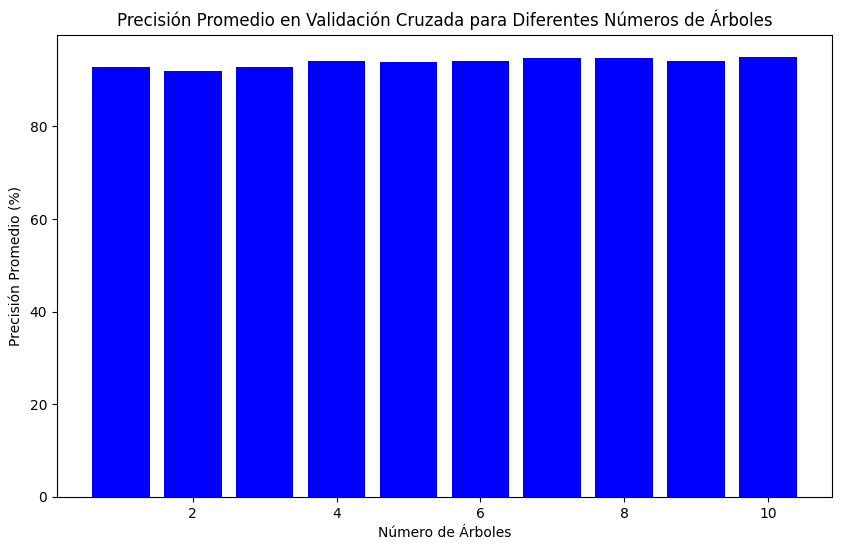

In [ ]:
import matplotlib.pyplot as plt

# Función para graficar las puntuaciones
def plot_scores(n_trees_values, scores_values, title):
    plt.figure(figsize=(10, 6))
    plt.bar(n_trees_values, scores_values, color='blue')
    plt.xlabel('Número de Árboles')
    plt.ylabel('Precisión Promedio (%)')
    plt.title(title)
    plt.show()

# Evaluar el algoritmo
n_folds = 5
max_depth = 3
min_size = 1
sample_size = 1.0
n_features = int(sqrt(len(dataset[0]) - 1))

# Almacena los resultados para cada configuración de n_trees
results = []

for n_trees in [1,2,3,4, 5,6,7,8,9, 10]:
    scores, _ = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
    mean_accuracy = sum(scores) / float(len(scores))
    results.append(mean_accuracy)

    # Imprimir información
    print('Trees: %d' % n_trees)
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f%%' % mean_accuracy)

# Graficar los resultados
plot_scores([1,2,3,4,5,6,7,8,9,10], results, 'Precisión Promedio en Validación Cruzada para Diferentes Números de Árboles')